In [46]:
import re
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from matplotlib.patches import Patch
from Bio import motifs
from Bio.Seq import Seq


# Setup

In [47]:
lothar = '/home/enno/uni/SS24/thesis/1_seq_analysis'

if os.getcwd() == lothar:
    pos_df = pd.read_csv('/home/enno/uni/SS24/thesis/data/hendecads/annoted.csv')
    
    clans_r5 = '/home/enno/uni/SS24/thesis/1_seq_analysis/5R_hendecad_strict_TMP_full_cd_out_30k1E-3_out.clans'
    fasta_r5 = '/home/enno/uni/SS24/thesis/1_seq_analysis/5R_hendecad_strict_TMP_full_cd_out.fasta'
    
    clans_r7 = '/home/enno/uni/SS24/thesis/CLANS/7R.clans'
    fasta_r5 = '/home/enno/uni/SS24/thesis/CLANS/7R.fasta'
else:
    pos_df = pd.read_csv('/ebio/abt1_share/prediction_hendecads/1_repo/2_ss_pred/dataset/annotated_df.csv')
    
    clans_r7 = '/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/5R/5R.clans'
    fasta_r5 = '/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/5R/5R.fasta'
    
    clans_r7 = '/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/7R/7R.clans'
    fasta_r7 = '/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/7R/7R.fasta'

In [48]:
# There are 5,851 TMP sequences and 1,607 TMP sequences with at least one 5R hit.
# There are a total of 11,235 5R hits across TMP sequences.
# These 11k hits were condensed to 4,585 hits by CD-HIT

tmp_df_5r = pos_df[(pos_df['reduced_group'] == 'TMP') & (pos_df['5R_hendecad_strict'] > 0)].reset_index(drop=True)
tmp_df_7r = pos_df[(pos_df['reduced_group'] == 'TMP') & (pos_df['7R_hendecad_strict'] > 0)].reset_index(drop=True)

In [49]:
def parse_numbers(filename):
    # Extracts the cluster assignment for 5R hits from the .clans file

    clusters = []
    with open(filename, 'r') as file:
       
        for line in file:
            
            if re.match('numbers=', line):
                
                _, num_str = line.split('=')
                numbers = [int(num.strip()) for num in num_str.split(';')[:-1]]

                clusters.append(numbers)
    
    return clusters

In [50]:
def parse_cluster_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    clusters = {}
    current_representative = None

    for line in lines:
        if line.startswith('>Cluster'):
            # This line is the start of a new cluster, so the next line will contain the representative sequence
            current_representative = None
        else:
            # This line contains a sequence
            sequence = line.split(', ')[1].split('...')[0].strip()
            if current_representative is None:
                # This is the first sequence in the cluster, so it's the representative sequence
                current_representative = sequence
            clusters[sequence[1:]] = current_representative[1:]

    return clusters

In [51]:
clusters_5r = parse_cluster_file('/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/5R/5R.clstr')
clusters_7r = parse_cluster_file('/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/7R/7R.clstr')

In [52]:
len(clusters_5r), len(clusters_7r)

(11223, 5406)

In [53]:
clusters_5r = parse_cluster_file('/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/5R/5R.clstr')
clusters_7r = parse_cluster_file('/ebio/abt1_share/prediction_hendecads/1_repo/1_seq_analysis/7R/7R.clstr')

In [54]:
numbers_5r = parse_numbers(clans_r5)
numbers_7r = parse_numbers(clans_r7)

In [55]:
C1_5r = numbers_5r[0]
C2_5r = numbers_5r[1]
C3_5r = numbers_5r[2]

C1_7r = numbers_7r[0]
C2_7r = numbers_7r[1]
C3_7r = numbers_7r[2]
C4_7r = numbers_7r[3]

In [56]:
with open (fasta_r5, 'r') as file:
    fasta_5r = file.readlines()

fasta_5r = [line.strip() for line in fasta_5r]

fasta_ids_5r = [sid[1:].split('[')[0][:-1] for sid in fasta_5r[::2]] 
fasta_ixs_5r = [eval(sid[1:].split('_')[-1]) for sid in fasta_5r[::2]]
fasta_seqs_5r = [seq.strip() for seq in fasta_5r[1::2]]

C1_fasta_5r = [fasta_ids_5r[ix] for ix in C1_5r]
C2_fasta_5r = [fasta_ids_5r[ix] for ix in C2_5r]
C3_fasta_5r = [fasta_ids_5r[ix] for ix in C3_5r]
CX_fasta_5r = [fid for ix, fid in enumerate(fasta_ids_5r) if ix not in C1_5r+C2_5r+C3_5r]  # +C4

C1_seqs_5r = [fasta_seqs_5r[ix] for ix in C1_5r]
C2_seqs_5r = [fasta_seqs_5r[ix] for ix in C2_5r]
C3_seqs_5r = [fasta_seqs_5r[ix] for ix in C3_5r]
CX_seqs_5r = [fid for ix, fid in enumerate(fasta_seqs_5r) if ix not in C1_5r+C2_5r+C3_5r]  # +C4

C1_stretch_5r = [fasta_ixs_5r[ix] for ix in C1_5r]
C2_stretch_5r = [fasta_ixs_5r[ix] for ix in C2_5r]
C3_stretch_5r = [fasta_ixs_5r[ix] for ix in C3_5r]
CX_stretch_5r = [fid for ix, fid in enumerate(fasta_ixs_5r) if ix not in C1_5r+C2_5r+C3_5r]  # +C4

C1_data_5r = list(zip(C1_fasta_5r, C1_stretch_5r))
C2_data_5r = list(zip(C2_fasta_5r, C2_stretch_5r))
C3_data_5r = list(zip(C3_fasta_5r, C3_stretch_5r))
CX_data_5r = list(zip(CX_fasta_5r, CX_stretch_5r))


In [65]:
with open (fasta_r7, 'r') as file:
    fasta_7r = file.readlines()

fasta_7r = [line.strip() for line in fasta_7r]

fasta_ids_7r = [sid[1:].split('[')[0][:-1] for sid in fasta_7r[::2]] 
fasta_ixs_7r = [eval(sid[1:].split('_')[-1]) for sid in fasta_7r[::2]]
fasta_seqs_7r = [seq.strip() for seq in fasta_7r[1::2]]

C1_fasta_7r = [fasta_ids_7r[ix] for ix in C1_7r]
C2_fasta_7r = [fasta_ids_7r[ix] for ix in C2_7r]
C3_fasta_7r = [fasta_ids_7r[ix] for ix in C3_7r]
C4_fasta_7r = [fasta_ids_7r[ix] for ix in C4_7r]
CX_fasta_7r = [fid for ix, fid in enumerate(fasta_ids_7r) if ix not in C1_7r+C2_7r+C3_7r+C4_7r] 

C1_seqs_7r = [fasta_seqs_7r[ix] for ix in C1_7r]
C2_seqs_7r = [fasta_seqs_7r[ix] for ix in C2_7r]
C3_seqs_7r = [fasta_seqs_7r[ix] for ix in C3_7r]
C4_seqs_7r = [fasta_seqs_7r[ix] for ix in C4_7r]
CX_seqs_7r = [fid for ix, fid in enumerate(fasta_seqs_7r) if ix not in C1_7r+C2_7r+C3_7r+C4_7r]

C1_stretch_7r = [fasta_ixs_7r[ix] for ix in C1_7r]
C2_stretch_7r = [fasta_ixs_7r[ix] for ix in C2_7r]
C3_stretch_7r = [fasta_ixs_7r[ix] for ix in C3_7r]
C4_stretch_7r = [fasta_ixs_7r[ix] for ix in C4_7r]
CX_stretch_7r = [fid for ix, fid in enumerate(fasta_ixs_7r) if ix not in C1_7r+C2_7r+C3_7r+C4_7r]

C1_data_7r = list(zip(C1_fasta_7r, C1_stretch_7r))
C2_data_7r = list(zip(C2_fasta_7r, C2_stretch_7r))
C3_data_7r = list(zip(C3_fasta_7r, C3_stretch_7r))
C4_data_7r = list(zip(C4_fasta_7r, C4_stretch_7r))
CX_data_7r = list(zip(CX_fasta_7r, CX_stretch_7r))


In [58]:
len(C1_fasta_5r) + len(C2_fasta_5r) + len(C3_fasta_5r) + len(CX_fasta_5r) # + len(C4_fasta)

4589

In [59]:
len(C1_fasta_5r), len(C2_fasta_5r), len(C3_fasta_5r), len(fasta_ids_5r), len(tmp_df_5r['id'])

(1846, 443, 455, 4585, 1607)

In [60]:
len(np.unique(C1_fasta_5r)), len(np.unique(C2_fasta_5r)), len(np.unique(C3_fasta_5r)), len(np.unique(fasta_ids_5r)), len(tmp_df_5r['id'].unique())

(543, 243, 182, 1529, 1540)

In [61]:
tmp_df_5r['C1'] = 0
tmp_df_5r['C2'] = 0
tmp_df_5r['C3'] = 0
tmp_df_5r['CX'] = 0

c1, c2, c3 = 0, 0, 0
unassigned, unhandled = 0, 0

for ix in range(len(tmp_df_5r)):

    current_seq = tmp_df_5r.iloc[ix]
    current_hits = eval(current_seq['5R_ix_hendecad_strict'])

    # if current_seq['id'] not in fasta_ids:
        # print(f'{current_seq["id"]} not in fasta_ids')
        # continue

    for hit_ix in current_hits:
        
        # this is a too lose check condition
        # id and hit_ix not only need to be in Ci but in the very same order
        if (current_seq['id'], list(hit_ix)) in C1_data_5r:   
            tmp_df_5r.loc[ix, 'C1'] += 1
            c1 += 1
        elif (current_seq['id'], list(hit_ix)) in C2_data_5r:
            tmp_df_5r.loc[ix, 'C2'] += 1
            c2 += 1
        elif (current_seq['id'], list(hit_ix)) in C3_data_5r:
            tmp_df_5r.loc[ix, 'C3'] += 1
            c3 += 1
        elif (current_seq['id'], list(hit_ix)) in CX_data_5r:
            tmp_df_5r.loc[ix, 'CX'] += 1
            unassigned += 1
        else:
            representative = clusters_5r[current_seq['id'] + '_' + str(list(hit_ix)).replace(' ', '')].split('[')
            rep_id = representative[0][:-1]
            rep_ix = eval('[' + representative[1])
            
            if (rep_id, rep_ix) in C1_data_5r:
                tmp_df_5r.loc[ix, 'C1'] += 1
                c1 += 1
            elif (rep_id, rep_ix) in C2_data_5r:
                tmp_df_5r.loc[ix, 'C2'] += 1
                c2 += 1
            elif (rep_id, rep_ix) in C3_data_5r:
                tmp_df_5r.loc[ix, 'C3'] += 1
                c3 += 1
            elif (rep_id, rep_ix) in CX_data_5r:
                tmp_df_5r.loc[ix, 'CX'] += 1
                unassigned += 1
            else:
                unhandled += 1

            
            # print("unhandled hit")
            # find representative and annotate accordingly!

tmp_df_5r['C1_norm'] = tmp_df_5r['C1'] / tmp_df_5r['5R_hendecad_strict']
tmp_df_5r['C2_norm'] = tmp_df_5r['C2'] / tmp_df_5r['5R_hendecad_strict']
tmp_df_5r['C3_norm'] = tmp_df_5r['C3'] / tmp_df_5r['5R_hendecad_strict']
tmp_df_5r['CX_norm'] = tmp_df_5r['CX'] / tmp_df_5r['5R_hendecad_strict']

c1, c2, c3, unassigned, c1 + c2 + c3 + unassigned, unhandled

(4711, 847, 1517, 4160, 11235, 0)

In [66]:
tmp_df_7r['C1'] = 0
tmp_df_7r['C2'] = 0
tmp_df_7r['C3'] = 0
tmp_df_7r['CX'] = 0
tmp_df_7r['C4'] = 0

c1, c2, c3, c4 = 0, 0, 0, 0
unassigned, unhandled = 0, 0

for ix in range(len(tmp_df_7r)):

    current_seq = tmp_df_7r.iloc[ix]
    current_hits = eval(current_seq['7R_ix_hendecad_strict'])

    # if current_seq['id'] not in fasta_ids:
        # print(f'{current_seq["id"]} not in fasta_ids')
        # continue

    for hit_ix in current_hits:
        
        # this is a too lose check condition
        # id and hit_ix not only need to be in Ci but in the very same order
        if (current_seq['id'], list(hit_ix)) in C1_data_7r:   
            tmp_df_7r.loc[ix, 'C1'] += 1
            c1 += 1
        elif (current_seq['id'], list(hit_ix)) in C2_data_7r:
            tmp_df_7r.loc[ix, 'C2'] += 1
            c2 += 1
        elif (current_seq['id'], list(hit_ix)) in C3_data_7r:
            tmp_df_7r.loc[ix, 'C3'] += 1
            c3 += 1
        elif (current_seq['id'], list(hit_ix)) in CX_data_7r:
            tmp_df_7r.loc[ix, 'CX'] += 1
            unassigned += 1
        elif (current_seq['id'], list(hit_ix)) in C4_data_7r:
            tmp_df_7r.loc[ix, 'C4'] += 1
            c4 += 1
        else:
            representative = clusters_7r[current_seq['id'] + '_' + str(list(hit_ix)).replace(' ', '')].split('[')
            rep_id = representative[0][:-1]
            rep_ix = eval('[' + representative[1])
            
            if (rep_id, rep_ix) in C1_data_7r:
                tmp_df_7r.loc[ix, 'C1'] += 1
                c1 += 1
            elif (rep_id, rep_ix) in C2_data_7r:
                tmp_df_7r.loc[ix, 'C2'] += 1
                c2 += 1
            elif (rep_id, rep_ix) in C3_data_7r:
                tmp_df_7r.loc[ix, 'C3'] += 1
                c3 += 1
            elif (rep_id, rep_ix) in CX_data_7r:
                tmp_df_7r.loc[ix, 'CX'] += 1
                unassigned += 1
            elif (rep_id, rep_ix) in C4_data_7r:
                tmp_df_7r.loc[ix, 'C4'] += 1
                c4 += 1
            else:
                unhandled += 1

            
            # print("unhandled hit")
            # find representative and annotate accordingly!

tmp_df_7r['C1_norm'] = tmp_df_7r['C1'] / tmp_df_7r['7R_hendecad_strict']
tmp_df_7r['C2_norm'] = tmp_df_7r['C2'] / tmp_df_7r['7R_hendecad_strict']
tmp_df_7r['C3_norm'] = tmp_df_7r['C3'] / tmp_df_7r['7R_hendecad_strict']
tmp_df_7r['CX_norm'] = tmp_df_7r['CX'] / tmp_df_7r['7R_hendecad_strict']
tmp_df_7r['C4_norm'] = tmp_df_7r['C4'] / tmp_df_7r['7R_hendecad_strict']

c1, c2, c3, c4, unassigned, c1 + c2 + c3 + c4 + unassigned, unhandled


(715, 1751, 314, 1004, 1623, 5407, 0)

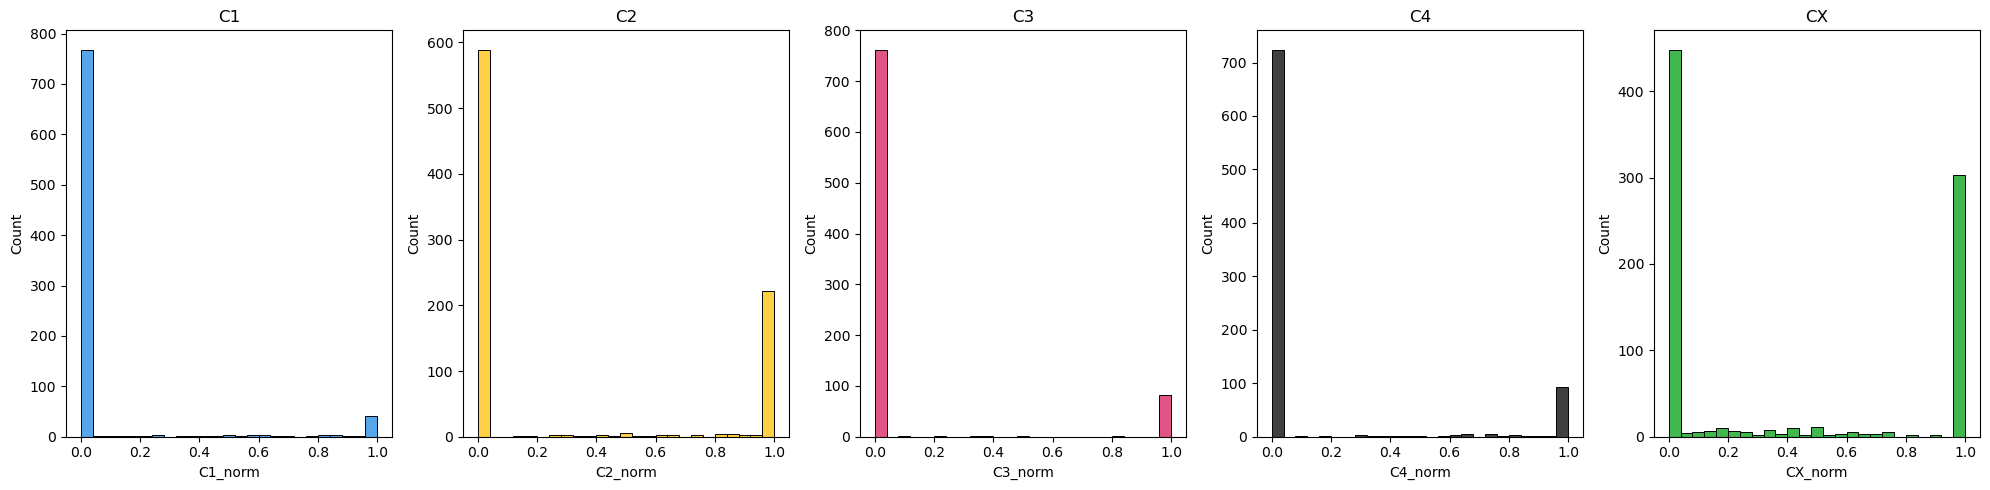

In [67]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

sns.histplot(tmp_df_7r['C1_norm'], bins=25, ax=axes[0], color='#1E88E5', label='C1')
sns.histplot(tmp_df_7r['C2_norm'], bins=25, ax=axes[1], color='#FFC107', label='C2')
sns.histplot(tmp_df_7r['C3_norm'], bins=25, ax=axes[2], color='#D81B60', label='C3')
sns.histplot(tmp_df_7r['C4_norm'], bins=25, ax=axes[3], color='#000000', label='C4')
sns.histplot(tmp_df_7r['CX_norm'], bins=25, ax=axes[4], color='#00A012', label='CX')

axes[0].set_title('C1')
axes[1].set_title('C2')
axes[2].set_title('C3')
axes[3].set_title('C4')
axes[4].set_title('CX')

plt.tight_layout()
plt.show()

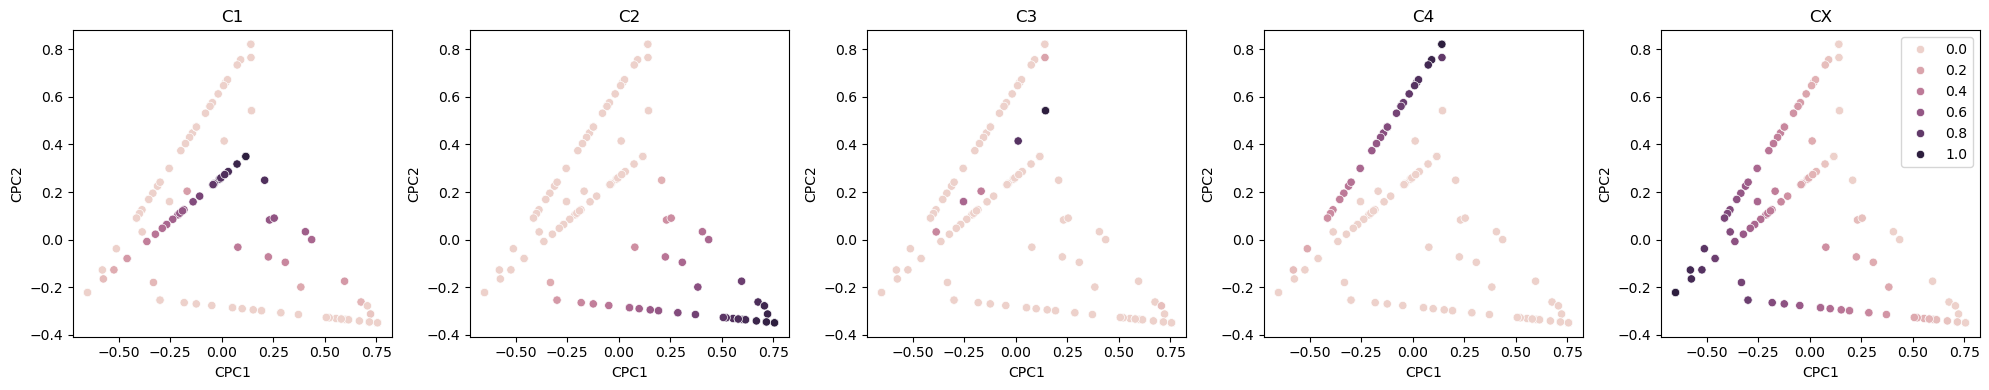

In [68]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

data_pca = pca.fit_transform(tmp_df_7r[['C1_norm', 'C2_norm', 'C3_norm', 'C4_norm', 'CX_norm']])
tmp_df_7r[['CPC1', 'CPC2']] = data_pca

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df_7r, ax=axes[0], hue='C1_norm')
sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df_7r, ax=axes[1], hue='C2_norm')
sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df_7r, ax=axes[2], hue='C3_norm')
sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df_7r, ax=axes[3], hue='C4_norm')
sns.scatterplot(x='CPC1', y='CPC2', data=tmp_df_7r, ax=axes[4], hue='CX_norm')


axes[0].set_title('C1')
axes[1].set_title('C2')
axes[2].set_title('C3')
axes[3].set_title('C4')
axes[4].set_title('CX')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
axes[4].legend(loc='upper right')

plt.tight_layout()
plt.show()


# CLANS

In [72]:
# Get cluster assignments for each 5R hit
cl_5r = []
for cx in range(len(fasta_5r[::2])):
    if cx in C1_5r:
        cl_5r.append(0)
    elif cx in C2_5r:
        cl_5r.append(1)
    elif cx in C3_5r:
        cl_5r.append(2)
    else:
        cl_5r.append(4)

In [73]:
cl_7r = []
for cx in range(len(fasta_7r[::2])):
    if cx in C1_7r:
        cl_7r.append(0)
    elif cx in C2_7r:
        cl_7r.append(1)
    elif cx in C3_7r:
        cl_7r.append(2)
    elif cx in C4_7r:
        cl_7r.append(3)
    else:
        cl_7r.append(4)

In [76]:
with open(clans_r5, 'r') as file:
    data_5r = file.readlines()

data_5r = [line.strip() for line in data_5r]

first_pos_5r = 9228 # 3334 
last_pos_5r = 13813  # 4969

pos_5r = [(float(x.split()[2]), float(x.split()[1])) for x in data_5r[first_pos_5r:last_pos_5r]]

x_5r = [int(x[0]) for x in pos_5r]
y_5r = [int(x[1]) for x in pos_5r]

hit_df_5r = pd.DataFrame({'id': fasta_ids_5r, 'x': x_5r, 'y': y_5r, 'cl': cl_5r})

tmp_df_5r['C'] = tmp_df_5r[['C1_norm', 'C2_norm', 'C3_norm', 'CX_norm']].idxmax(axis=1)

In [77]:
with open(clans_r7, 'r') as file:
    data_7r = file.readlines()

data_7r = [line.strip() for line in data_7r]

first_pos_7r = 3334
last_pos_7r = 4969

pos_7r = [(float(x.split()[2]), float(x.split()[1])) for x in data_7r[first_pos_7r:last_pos_7r]]

x_7r = [int(x[0]) for x in pos_7r]
y_7r = [int(x[1]) for x in pos_7r]

hit_df_7r = pd.DataFrame({'id': fasta_ids_7r, 'x': x_7r, 'y': y_7r, 'cl': cl_7r})

tmp_df_7r['C'] = tmp_df_7r[['C1_norm', 'C2_norm', 'C3_norm', 'C4_norm', 'CX_norm']].idxmax(axis=1)

In [80]:
# randomly sample 10 hits from C1
sample_5r = tmp_df_5r[tmp_df_5r['C'] == 'C2_norm'].sample(10)
test_ids = sample_5r['id'].unique()
sample_5r = hit_df_5r[hit_df_5r['id'].isin(test_ids)]

sample_7r = tmp_df_7r[tmp_df_7r['C'] == 'C2_norm'].sample(10)
test_ids = sample_7r['id'].unique()
sample_7r = hit_df_7r[hit_df_7r['id'].isin(test_ids)]

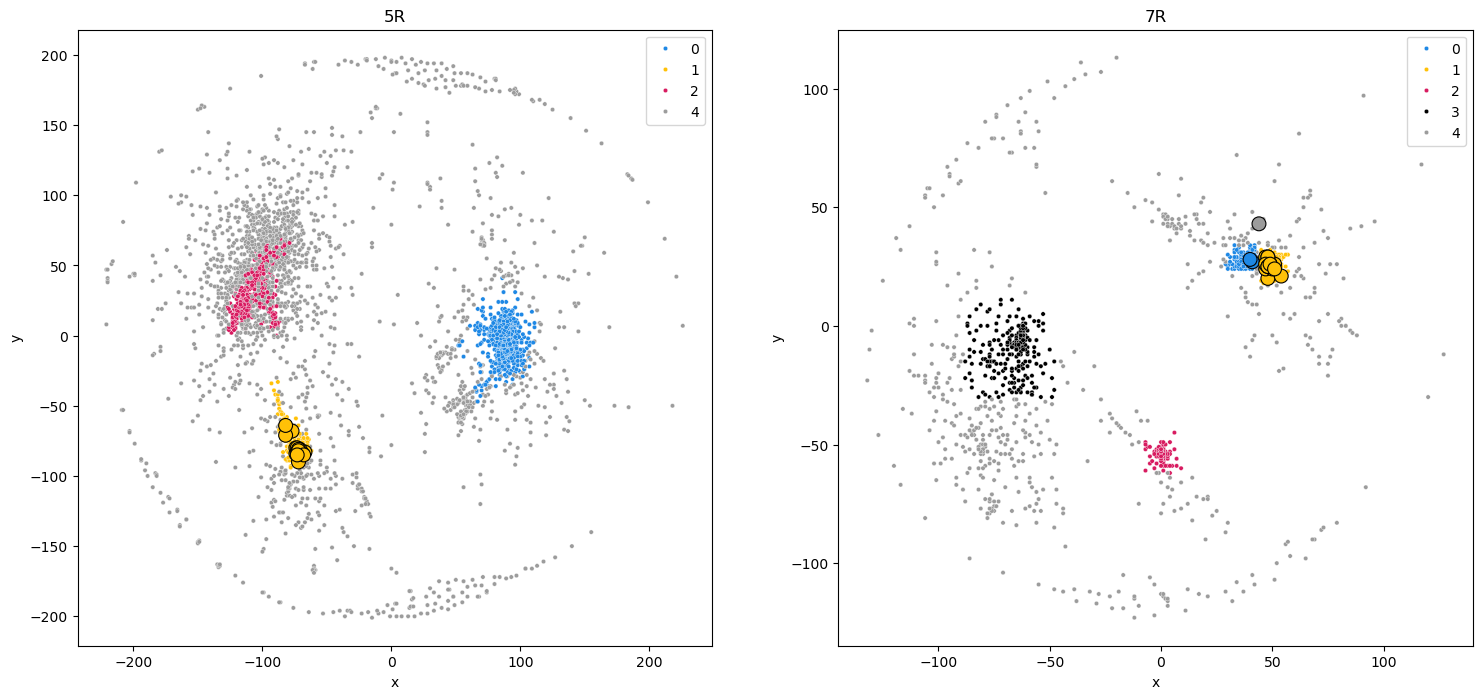

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

pal_5r = ['#1E88E5', '#FFC107', '#D81B60', '#9c9c9c']
pal_7r = ['#1E88E5', '#FFC107', '#D81B60', '#000000', '#9c9c9c']

sns.scatterplot(data=hit_df_5r, x='x', y='y', hue='cl', palette=pal_5r, s=10, ax=axes[0])
sns.scatterplot(data=sample_5r, x='x', y='y', hue='cl', palette=pal_5r[1:2], s=100, edgecolor='black', ax=axes[0])

sns.scatterplot(data=hit_df_7r, x='x', y='y', hue='cl', palette=pal_7r, s=10, ax=axes[1])
sns.scatterplot(data=sample_7r, x='x', y='y', hue='cl', palette=pal_7r[0:2] + pal_7r[-1:], s=100, edgecolor='black', ax=axes[1])

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[:4], labels=labels[:4])
axes[0].set_title('5R')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[:5], labels=labels[:5])
axes[1].set_title('7R')

plt.show()

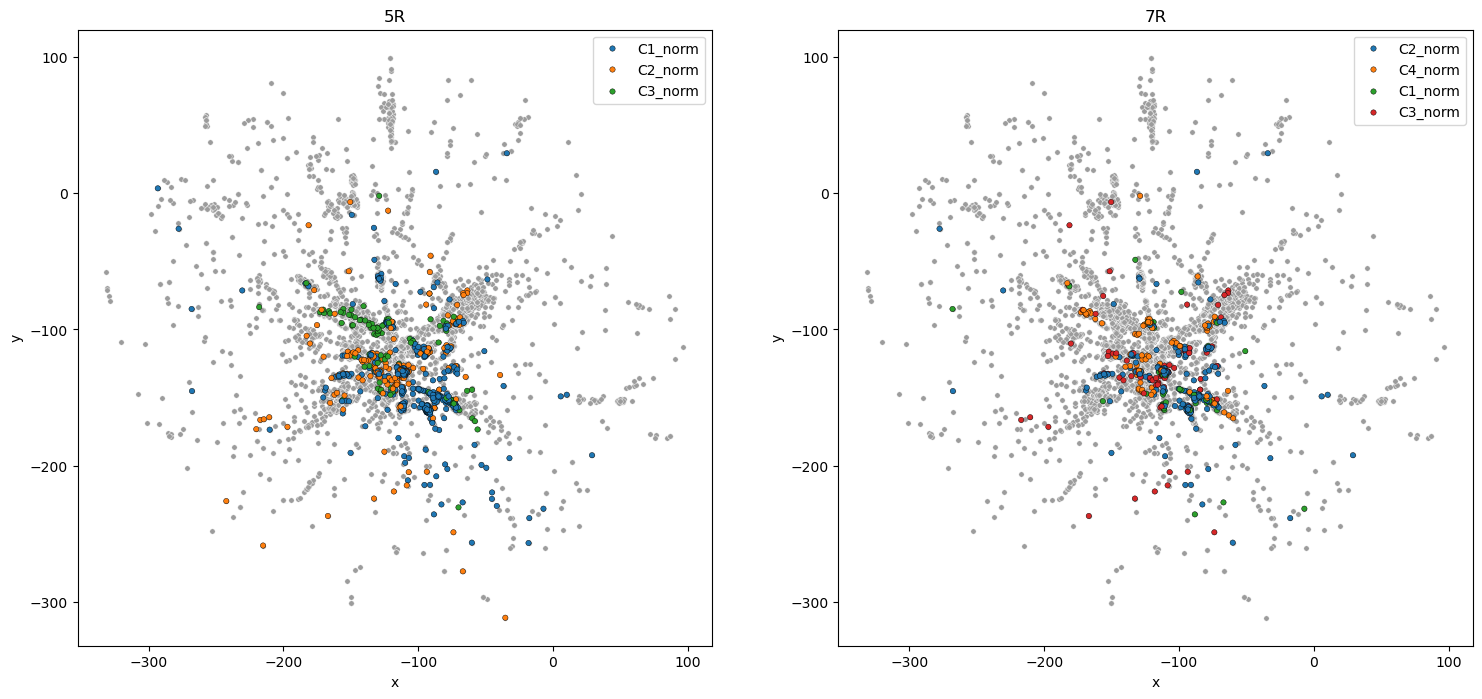

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

pal_5r = ['#1E88E5', '#FFC107', '#D81B60', '#9c9c9c']
pal_7r = ['#1E88E5', '#FFC107', '#D81B60', '#000000', '#9c9c9c']

sns.scatterplot(data=pos_df[pos_df.reduced_group == 'TMP'], x='x', y='y', s=15, c='#9c9c9c', ax=axes[0])
sns.scatterplot(data=tmp_df_5r[tmp_df_5r['C'] != 'CX_norm'], x='x', y='y', edgecolor='black', ax=axes[0], s=15, hue='C')

sns.scatterplot(data=pos_df[pos_df.reduced_group == 'TMP'], x='x', y='y', s=15, c='#9c9c9c', ax=axes[1])
sns.scatterplot(data=tmp_df_7r[tmp_df_7r['C'] != 'CX_norm'], x='x', y='y', edgecolor='black', ax=axes[1], s=15, hue='C')

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[:4], labels=labels[:4])
axes[0].set_title('5R')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[:5], labels=labels[:5])
axes[1].set_title('7R')

plt.show()